In [1]:
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---------------------------------------------------------
# 1. DESCARGA DE DATOS (Actualizada con margen extra)
# ---------------------------------------------------------
print("Verificando archivos de datos...")
try:
    # Altura de ola (Misma config)
    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
        variables=["VHM0"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,     # Ampliado un poco al norte (21)
        start_datetime="2025-08-15T21:00:00",
        end_datetime="2025-08-22T21:00:00",
        output_filename="AlturaOla.nc",
        force_download=True 
    )

    # Corrientes (Dato diario P1D)
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
        variables=["ugos", "vgos"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,
        start_datetime="2025-08-15T00:00:00",
        end_datetime="2025-11-22T00:00:00",
        output_filename="Corrientes.nc",
        force_download=True
    )
    print("Datos listos.")
except Exception as e:
    print(f"Nota sobre descarga: {e}")

print("Descarga completada (o archivos ya existentes).")



c:\Users\maret\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING - 2025-11-25T20:01:37Z - 'force_download' has been deprecated.


Verificando archivos de datos...


INFO - 2025-11-25T20:01:42Z - Selected dataset version: "202411"
INFO - 2025-11-25T20:01:42Z - Selected dataset part: "default"
INFO - 2025-11-25T20:01:58Z - Starting download. Please wait...
100%|██████████| 50/50 [01:41<00:00,  2.03s/it]
INFO - 2025-11-25T20:03:40Z - Successfully downloaded to AlturaOla.nc
WARNING - 2025-11-25T20:03:40Z - 'force_download' has been deprecated.
INFO - 2025-11-25T20:03:46Z - Selected dataset version: "202506"
INFO - 2025-11-25T20:03:46Z - Selected dataset part: "default"
INFO - 2025-11-25T20:04:11Z - Starting download. Please wait...
100%|██████████| 16/16 [01:19<00:00,  4.97s/it]
INFO - 2025-11-25T20:05:30Z - Successfully downloaded to Corrientes.nc


Datos listos.
Descarga completada (o archivos ya existentes).


In [2]:
# ---------------------------------------------------------
# 2. CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)
# ---------------------------------------------------------
print("\n--- Generando Semillas de Inicio ---")

# Lista para guardar las partículas. 
# Cada partícula será un diccionario con sus listas de historial.
particulas = []

# Definir puntos específicos
puntos_fijos = [
    {"lat": 20.0, "lon": -72.0, "label": "Punto N-O (20N, 72W)"},
    {"lat": 17.0, "lon": -72.0, "label": "Punto S-O (17N, 72W)"}
]

# Agregar puntos fijos a la lista
for p in puntos_fijos:
    particulas.append({
        "lat_history": [p["lat"]],
        "lon_history": [p["lon"]],
        "active": True, # Para saber si sigue dentro del mapa
        "label": p["label"],
        "color": "red" # Color distintivo
    })

# Definir línea a lo largo de 68°O (entre 17N y 20N)
# np.linspace crea puntos equidistantes
latitudes_linea = np.linspace(17, 20, num=10) # Creamos 10 partículas a lo largo de la línea
longitud_linea = -68.0

for lat in latitudes_linea:
    particulas.append({
        "lat_history": [lat],
        "lon_history": [longitud_linea],
        "active": True,
        "label": "Línea 68W", # Etiqueta genérica
        "color": "orange" # Color para el grupo de la línea
    })

print(f"Total de partículas creadas: {len(particulas)}")




--- Generando Semillas de Inicio ---
Total de partículas creadas: 12


In [3]:
# ---------------------------------------------------------
# 3. SIMULACIÓN DE DERIVA (Multi-partícula)
# ---------------------------------------------------------
print("Calculando trayectorias...")
ds_curr = xr.open_dataset("Corrientes.nc")
times = ds_curr.time.values
dt = 24 * 3600  # 1 día en segundos

for t in times:
    # Cargar el slice de tiempo UNA sola vez por día para optimizar
    try:
        current_slice = ds_curr.sel(time=t)
    except KeyError:
        break # Fin de datos

    # Iterar sobre cada partícula
    todos_inactivos = True
    for p in particulas:
        if not p["active"]:
            continue
        
        todos_inactivos = False
        
        # Última posición conocida
        lat_actual = p["lat_history"][-1]
        lon_actual = p["lon_history"][-1]

        try:
            # Interpolación (method='linear' es más suave, 'nearest' es más rápido)
            # Usamos nearest para evitar NaNs en bordes costeros complejos
            u = float(current_slice['ugos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)
            v = float(current_slice['vgos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)

            if np.isnan(u) or np.isnan(v):
                p["active"] = False # Tocó tierra o salió del mapa
                continue

            # Cálculo de desplazamiento
            dx = u * dt
            dy = v * dt
            
            d_lat = dy / 111132.0
            d_lon = dx / (111132.0 * np.cos(np.radians(lat_actual)))
            
            # Actualizar
            p["lat_history"].append(lat_actual + d_lat)
            p["lon_history"].append(lon_actual + d_lon)

        except Exception:
            p["active"] = False
            continue
    
    if todos_inactivos:
        print(f"Todas las partículas salieron del dominio en {t}")
        break

Calculando trayectorias...


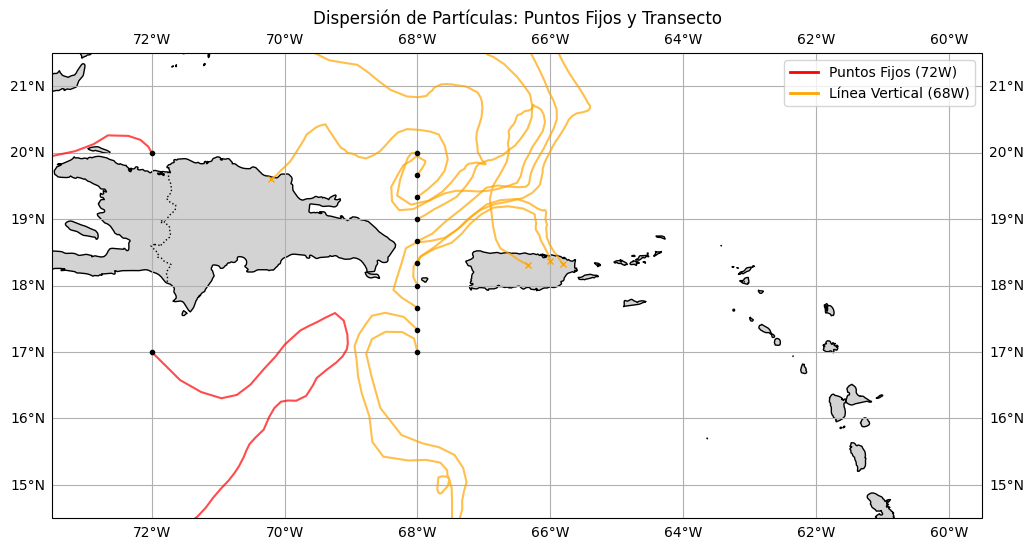

In [4]:
# ---------------------------------------------------------
# 4. GRAFICAR RESULTADOS
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-73.5, -59.5, 14.5, 21.5], crs=ccrs.PlateCarree())

# Mapa base
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Dibujar trayectorias
for p in particulas:
    # Línea de trayectoria
    ax.plot(p["lon_history"], p["lat_history"], 
            color=p["color"], linewidth=1.5, alpha=0.7, 
            transform=ccrs.PlateCarree())
    
    # Punto de inicio
    ax.plot(p["lon_history"][0], p["lat_history"][0], 
            marker='o', color='black', markersize=3, 
            transform=ccrs.PlateCarree())
    
    # Punto final (flecha o X)
    ax.plot(p["lon_history"][-1], p["lat_history"][-1], 
            marker='x', color=p["color"], markersize=5, 
            transform=ccrs.PlateCarree())

# Truco para la leyenda personalizada (evitar 12 entradas iguales)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax.legend(custom_lines, ['Puntos Fijos (72W)', 'Línea Vertical (68W)'], loc='upper right')

plt.title("Dispersión de Partículas: Puntos Fijos y Transecto")
plt.show()